In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from google.colab import drive

# --- Import tambahan untuk metrik, plotting, dan progress bar ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm # <-- IMPORT PENTING UNTUK PROGRESS BAR

# --- 1. Konfigurasi dan Hiperparameter ---

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Menggunakan device: {DEVICE}")

Menggunakan device: cuda


In [ ]:
IMAGE_SIZE = 384
BATCH_SIZE = 32 # Sesuaikan jika perlu
LR_FEATURE_EXTRACTION = 1e-3
LR_FINE_TUNING = 1e-5

EPOCHS_FEATURE_EXTRACTION = 3 # Epoch pemanasan untuk head
MAX_EPOCHS_FINE_TUNING = 100  # Epoch maksimal untuk fine-tuning
EARLY_STOPPING_PATIENCE = 5  # Jumlah epoch untuk menunggu jika tidak ada peningkatan

# --- Mount Google Drive (KHUSUS COLAB) ---

In [ ]:
print("Mounting Google Drive...")
drive.mount('/content/drive')
print("Google Drive mounted.")

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted.


# --- 2. Memuat Data Anda Menggunakan ImageFolder ---

In [ ]:
DATA_DIR = '/content/drive/MyDrive/train_with_label'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
full_dataset = ImageFolder(root=DATA_DIR, transform=transform)
print(f"Dataset dimuat. Ditemukan {len(full_dataset)} gambar.")

Dataset dimuat. Ditemukan 3952 gambar.


In [ ]:
class_names = full_dataset.classes
NUM_CLASSES = len(class_names)
print(f"Ditemukan {NUM_CLASSES} kelas: {class_names}")

Ditemukan 15 kelas: ['Ayam Bakar', 'Ayam Betutu', 'Ayam Goreng', 'Ayam Pop', 'Bakso', 'Coto Makassar', 'Gado Gado', 'Gudeg', 'Nasi Goreng', 'Pempek', 'Rawon', 'Rendang', 'Sate Madura', 'Sate Padang', 'Soto']


In [ ]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])
print(f"Data latih: {len(train_dataset)}")
print(f"Data validasi: {len(val_dataset)}")

Data latih: 3161
Data validasi: 791


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. Memuat Model Pre-trained ViT ---

In [ ]:
print("\nMemuat model ViT pre-trained...")
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1)


Memuat model ViT pre-trained...
Downloading: "https://download.pytorch.org/models/vit_b_16_swag-9ac1b537.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16_swag-9ac1b537.pth


100%|██████████| 331M/331M [00:20<00:00, 17.2MB/s]


# --- 4. Tahap 1: Feature Extraction (dengan TQDM) ---

## Bekukan semua parameter di base model

In [ ]:
# for param in model.parameters():
#     param.requires_grad = False

In [ ]:
in_features = model.heads.head.in_features
model.heads.head = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(in_features, NUM_CLASSES)
)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.heads.head.parameters(), lr=LR_FEATURE_EXTRACTION)

In [ ]:
# for epoch in range(EPOCHS_FEATURE_EXTRACTION):
#     model.train()
#     running_loss = 0.0
#     running_correct = 0
#     running_total = 0

#     # Bungkus train_loader dengan tqdm
#     loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS_FEATURE_EXTRACTION}")

#     for inputs, labels in loop:
#         inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()

#         # Hitung akurasi
#         _, predicted = torch.max(outputs.data, 1)
#         running_total += labels.size(0)
#         running_correct += (predicted == labels).sum().item()

#         # Update progress bar
#         loop.set_postfix(
#             loss=(running_loss / (loop.n + 1)),
#             accuracy=(running_correct / running_total)
#         )

# print('Tahap 1 Selesai.')

# --- 5. Tahap 2: Fine-Tuning (dengan TQDM dan Early Stopping) ---

In [ ]:
print("\n--- Memulai Pelatihan Tahap 2 (Fine-Tuning) ---")

for param in model.parameters():
    param.requires_grad = True
optimizer = optim.Adam(model.parameters(), lr=LR_FINE_TUNING)

history = {
    'train_loss': [],
    'train_accuracy': [],
    'val_loss': [],
    'val_accuracy': []
}

best_val_loss = float('inf')
patience_counter = 0
best_epoch = 0

for epoch in range(MAX_EPOCHS_FINE_TUNING):
    # --- Training Phase ---
    model.train()
    running_train_loss = 0.0
    running_train_correct = 0
    running_train_total = 0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} [Train]", leave=False)

    for inputs, labels in train_loop:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        running_train_total += labels.size(0)
        running_train_correct += (predicted == labels).sum().item()

        train_loop.set_postfix(
            loss=(running_train_loss / (train_loop.n + 1)),
            accuracy=(running_train_correct / running_train_total)
        )

    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_acc = running_train_correct / running_train_total

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    running_val_correct = 0
    running_val_total = 0

    val_loop = tqdm(val_loader, desc=f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} [Val]", leave=False)

    with torch.no_grad():
        for inputs, labels in val_loop:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            running_val_total += labels.size(0)
            running_val_correct += (predicted == labels).sum().item()

            val_loop.set_postfix(
                val_loss=(running_val_loss / (val_loop.n + 1)),
                val_accuracy=(running_val_correct / running_val_total)
            )

    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_acc = running_val_correct / running_val_total

    print(f"Epoch {epoch + 1}/{MAX_EPOCHS_FINE_TUNING} - "
          f"loss: {avg_train_loss:.4f} - accuracy: {avg_train_acc:.4f} - "
          f"val_loss: {avg_val_loss:.4f} - val_accuracy: {avg_val_acc:.4f}")

    # --- Menyimpan nilai ke history ---
    # <-- BARU
    history['train_loss'].append(avg_train_loss)
    history['train_accuracy'].append(avg_train_acc)
    history['val_loss'].append(avg_val_loss)
    history['val_accuracy'].append(avg_val_acc)

    # --- Logika Early Stopping ---
    if avg_val_loss < best_val_loss:
        print(f'   Val loss membaik ({best_val_loss:.4f} --> {avg_val_loss:.4f}). Menyimpan model...')
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        best_epoch = epoch + 1
    else:
        patience_counter += 1
        print(f'   Val loss tidak membaik. Patience: {patience_counter}/{EARLY_STOPPING_PATIENCE}')

    if patience_counter >= EARLY_STOPPING_PATIENCE:
        print(f'Early stopping dipicu pada epoch {epoch + 1}!')
        break

print(f'Tahap 2 Selesai. Model terbaik disimpan dari epoch {best_epoch}.')


--- Memulai Pelatihan Tahap 2 (Fine-Tuning) ---


Epoch 1/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 1/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 1/100 - loss: 1.2380 - accuracy: 0.6264 - val_loss: 0.5311 - val_accuracy: 0.8559
   Val loss membaik (inf --> 0.5311). Menyimpan model...


Epoch 2/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 2/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 2/100 - loss: 0.4478 - accuracy: 0.8712 - val_loss: 0.4174 - val_accuracy: 0.8799
   Val loss membaik (0.5311 --> 0.4174). Menyimpan model...


Epoch 3/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 3/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 3/100 - loss: 0.2937 - accuracy: 0.9124 - val_loss: 0.4532 - val_accuracy: 0.8673
   Val loss tidak membaik. Patience: 1/5


Epoch 4/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 4/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 4/100 - loss: 0.1818 - accuracy: 0.9427 - val_loss: 0.4486 - val_accuracy: 0.8786
   Val loss tidak membaik. Patience: 2/5


Epoch 5/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 5/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 5/100 - loss: 0.1306 - accuracy: 0.9624 - val_loss: 0.4288 - val_accuracy: 0.8812
   Val loss tidak membaik. Patience: 3/5


Epoch 6/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 6/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 6/100 - loss: 0.0652 - accuracy: 0.9839 - val_loss: 0.4933 - val_accuracy: 0.8660
   Val loss tidak membaik. Patience: 4/5


Epoch 7/100 [Train]:   0%|          | 0/99 [00:00<?, ?it/s]

Epoch 7/100 [Val]:   0%|          | 0/25 [00:00<?, ?it/s]

Epoch 7/100 - loss: 0.0654 - accuracy: 0.9801 - val_loss: 0.4623 - val_accuracy: 0.8900
   Val loss tidak membaik. Patience: 5/5
Early stopping dipicu pada epoch 7!
Tahap 2 Selesai. Model terbaik disimpan dari epoch 2.



--- Riwayat Pelatihan ---
{'train_loss': [1.2380126434745211, 0.4478134043288953, 0.2937217838685922, 0.18181678001778295, 0.13061348254782984, 0.06521286103742743, 0.0653749474164362], 'train_accuracy': [0.6263840556785827, 0.8712432774438469, 0.9123695033217336, 0.9427396393546346, 0.9623536855425499, 0.9838658652325214, 0.9800695982284088], 'val_loss': [0.5311457586288452, 0.4173896938562393, 0.45320667266845704, 0.44861318945884704, 0.42880201995372774, 0.49332366943359374, 0.462311307489872], 'val_accuracy': [0.8558786346396966, 0.8798988621997471, 0.8672566371681416, 0.8786346396965866, 0.8811630847029077, 0.865992414664981, 0.8900126422250316]}


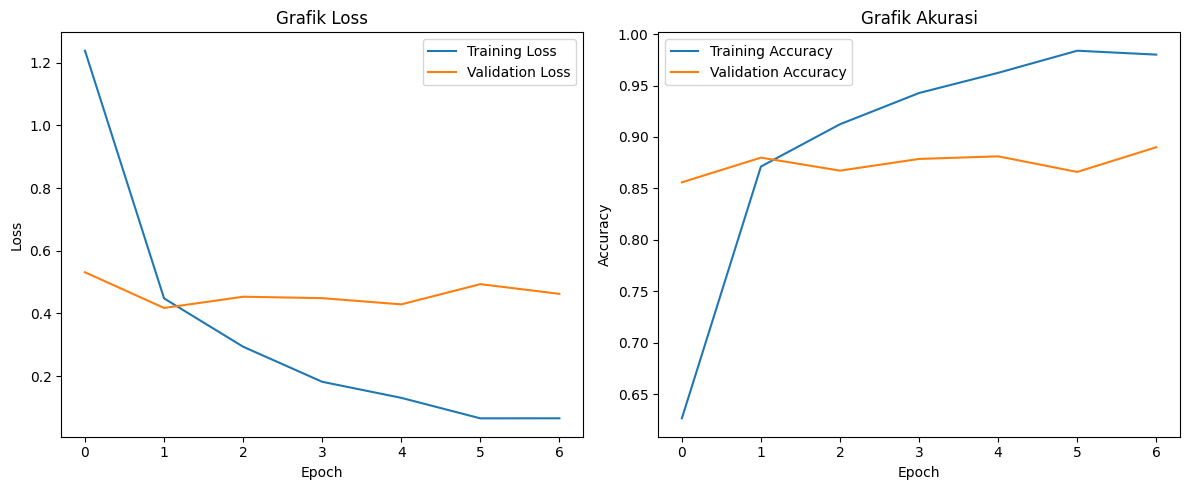

In [ ]:
print("\n--- Riwayat Pelatihan ---")
print(history)

# Buat plot
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history['train_accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# --- 6. Evaluasi Model (Laporan & Confusion Matrix) ---


--- Evaluasi Model Final (dari best_model.pth) ---
Akurasi pada 791 gambar validasi: 87.74 %
----------------------------------------------------------------------
Classification Report:
               precision    recall  f1-score   support

   Ayam Bakar       0.86      0.86      0.86        58
  Ayam Betutu       0.79      0.84      0.82        45
  Ayam Goreng       0.74      0.83      0.79        66
     Ayam Pop       0.98      0.74      0.84        62
        Bakso       0.95      0.92      0.93        60
Coto Makassar       0.73      0.86      0.79        43
    Gado Gado       0.98      0.88      0.93        51
        Gudeg       1.00      0.84      0.92        45
  Nasi Goreng       0.87      0.98      0.92        56
       Pempek       0.98      0.94      0.96        53
        Rawon       0.98      0.90      0.94        52
      Rendang       0.85      0.98      0.91        46
  Sate Madura       0.84      0.89      0.87        47
  Sate Padang       0.87      0.85      0

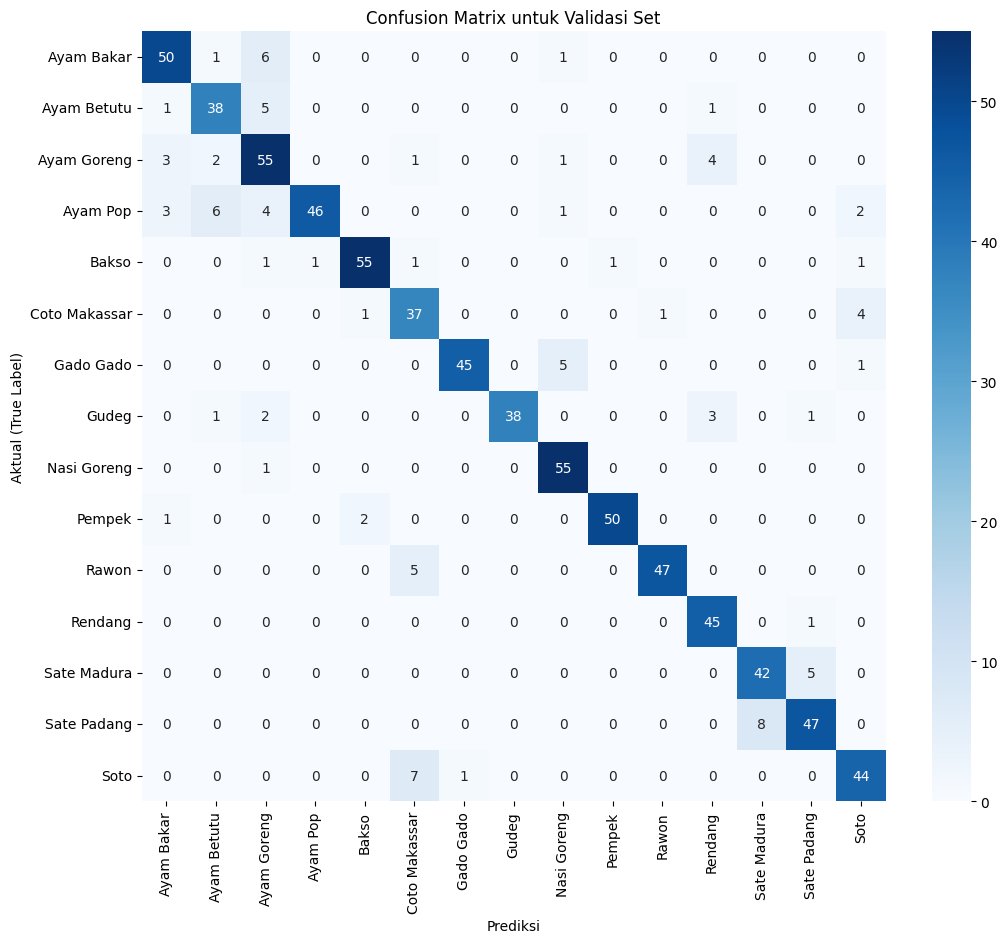

In [ ]:
# --- 6. Evaluasi Model (Laporan & Confusion Matrix) ---
# (Bagian ini tetap sama, tidak perlu diubah)
print("\n--- Evaluasi Model Final (dari best_model.pth) ---")

model.load_state_dict(torch.load('best_model.pth'))
model.eval()

all_labels = []
all_preds = []
correct = 0
total = 0

with torch.no_grad():
    for data in val_loader: # Menggunakan val_loader untuk evaluasi
        images, labels = data
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# 1. Cetak Akurasi Keseluruhan
accuracy = 100 * correct / total
print(f'Akurasi pada {total} gambar validasi: {accuracy:.2f} %')
print("-" * 70)

# 2. Cetak Classification Report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
print("-" * 70)

# 3. Buat dan Tampilkan Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Aktual (True Label)')
plt.title('Confusion Matrix untuk Validasi Set')
plt.show()

# Prediksi (Inference)

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
from tqdm.auto import tqdm

# --- 1. Konfigurasi Path ---
TEST_DIR = '/content/drive/MyDrive/test/test'
CSV_OUTPUT_PATH = '/content/drive/MyDrive/submission.csv'

# --- 2. Transformasi untuk Validasi/Tes ---
# (Tanpa augmentasi, hanya resize dan normalisasi)
transform_val = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 3. Custom Dataset untuk Folder Tes ---
# Dataset ini memuat gambar dari folder datar (tanpa sub-folder label)

from torch.utils.data import Dataset # Import Dataset class
class CustomTestDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        # Cari semua file gambar (jpg, jpeg, png)
        self.img_paths = glob.glob(os.path.join(img_dir, '*.jpg')) + \
                         glob.glob(os.path.join(img_dir, '*.jpeg')) + \
                         glob.glob(os.path.join(img_dir, '*.png'))
        self.transform = transform

        if not self.img_paths:
            print(f"Peringatan: Tidak ada gambar .jpg, .jpeg, atau .png yang ditemukan di {img_dir}")

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # Buka gambar
        image = Image.open(img_path).convert('RGB')

        # Terapkan transformasi
        if self.transform:
            image = self.transform(image)

        # Ekstrak ID (nama file tanpa ekstensi)
        # misal: '/content/drive/MyDrive/test/1.jpg' -> '1'
        file_id = os.path.splitext(os.path.basename(img_path))[0]

        return image, file_id

# --- 4. Memuat Data Tes ---
print(f"Memuat data tes dari: {TEST_DIR}")
test_dataset = CustomTestDataset(img_dir=TEST_DIR, transform=transform_val)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0) # Set num_workers to 0

print(f"Ditemukan {len(test_dataset)} gambar untuk diprediksi.")

# --- 5. Memuat Model yang Sudah Dilatih ---
print("Memuat model 'best_model.pth'...")

# Asumsi: Variabel NUM_CLASSES dan class_names ADA dari sel sebelumnya
if 'NUM_CLASSES' not in locals():
    print("Error: Variabel 'NUM_CLASSES' tidak ditemukan. Jalankan sel pelatihan dulu.")
else:
    # 1. Buat ulang arsitektur model (HARUS SAMA DENGAN MODEL YANG DISIMPAN)
    model = models.vit_b_16(weights=None, image_size=IMAGE_SIZE)
    in_features = model.heads.head.in_features

    # 2. Buat ulang head klasifikasi (TERMASUK DROPOUT)
    model.heads.head = nn.Sequential(
        nn.Dropout(p=0.5), # <-- INI HARUS SAMA DENGAN SEL 18
        nn.Linear(in_features, NUM_CLASSES)
    )

    # 3. Muat bobot (weights) terbaik yang disimpan
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Model berhasil dimuat.")
    except RuntimeError as e:
        print(f"Error loading state_dict: {e}")
        print("Attempting to load with strict=False to handle potential key mismatches.")
        model.load_state_dict(torch.load('best_model.pth'), strict=False)
        print("Model loaded with strict=False.")

    model = model.to(DEVICE)
    model.eval() # PENTING: Set model ke mode evaluasi (ini akan menonaktifkan dropout)


    # --- 6. Melakukan Prediksi ---
    results = []

    with torch.no_grad(): # Matikan gradien untuk inferensi
        for images, file_ids in tqdm(test_loader, desc="Melakukan Prediksi"):
            images = images.to(DEVICE)

            # Dapatkan output model
            outputs = model(images)

            # Dapatkan prediksi (indeks dengan nilai tertinggi)
            _, predicted_indices = torch.max(outputs.data, 1)

            # Ubah indeks ke nama kelas
            predicted_labels = [class_names[i] for i in predicted_indices]

            # Simpan hasil (ID file dan label prediksi)
            for i in range(len(file_ids)):
                results.append([file_ids[i], predicted_labels[i]])

    # --- 7. Menyimpan Hasil ke CSV ---
    print("Prediksi selesai. Menyimpan ke CSV...")

    # Buat DataFrame Pandas dari hasil
    df = pd.DataFrame(results, columns=['ID', 'label'])

    # Urutkan berdasarkan ID (jika ID-nya adalah angka)
    try:
        df['ID_num'] = df['ID'].astype(int)
        df = df.sort_values(by='ID_num').drop(columns=['ID_num'])
    except ValueError:
        # Jika ID bukan angka (misal: 'img_a', 'img_b'), urutkan berdasarkan alfabet
        df = df.sort_values(by='ID')

    # Simpan ke file CSV
    df.to_csv(CSV_OUTPUT_PATH, index=False)

    print(f"Berhasil! Hasil prediksi disimpan di: {CSV_OUTPUT_PATH}")

    # Tampilkan 5 baris pertama dari hasil
    print("\nContoh 5 baris pertama dari hasil:")
    print(df.head())

Memuat data tes dari: /content/drive/MyDrive/test/test
Ditemukan 2057 gambar untuk diprediksi.
Memuat model 'best_model.pth'...
Model berhasil dimuat.


Melakukan Prediksi:   0%|          | 0/65 [00:00<?, ?it/s]

Prediksi selesai. Menyimpan ke CSV...
Berhasil! Hasil prediksi disimpan di: /content/drive/MyDrive/submission.csv

Contoh 5 baris pertama dari hasil:
       ID        label
934  0001  Sate Padang
896  0002  Nasi Goreng
943  0003  Ayam Goreng
899  0004      Rendang
911  0005  Ayam Goreng


In [ ]:
from google.colab import files

try:
    files.download('best_model.pth')
    print("File 'best_model.pth' berhasil didownload.")
except FileNotFoundError:
    print("Error: File 'best_model.pth' tidak ditemukan. Pastikan model sudah disimpan sebelumnya.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

File 'best_model.pth' berhasil didownload.
